In [ ]:
from google.colab import files
import os

In [ ]:
print("Upload your kaggle.json (dans ~/.kaggle/kaggle.json)")
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
os.replace('kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

Upload your kaggle.json (dans ~/.kaggle/kaggle.json)


Saving kaggle.json to kaggle.json


In [ ]:
# Télécharger le dataset UNSW-NB15
!kaggle datasets download -d dhoogla/unswnb15

# Dézipper les fichiers
!unzip -q unswnb15.zip -d ./unswnb15

Dataset URL: https://www.kaggle.com/datasets/dhoogla/unswnb15
License(s): CC-BY-NC-SA-4.0
unswnb15.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./unswnb15/UNSW_NB15_testing-set.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./unswnb15/UNSW_NB15_training-set.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import missingno as msno
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, save_model

plt.style.use('ggplot')

In [ ]:
train_path = './unswnb15/UNSW_NB15_training-set.parquet'
test_path  = './unswnb15/UNSW_NB15_testing-set.parquet'

df_train = pd.read_parquet(train_path)
df_test  = pd.read_parquet(test_path)
df = pd.concat([df_train, df_test], ignore_index=True)
print(f"Loaded: train={df_train.shape}, test={df_test.shape}, combined={df.shape}")
df.info()

Loaded: train=(175341, 36), test=(82332, 36), combined=(257673, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                257673 non-null  float32 
 1   proto              257673 non-null  object  
 2   service            257673 non-null  category
 3   state              257673 non-null  object  
 4   spkts              257673 non-null  int16   
 5   dpkts              257673 non-null  int16   
 6   sbytes             257673 non-null  int32   
 7   dbytes             257673 non-null  int32   
 8   rate               257673 non-null  float32 
 9   sload              257673 non-null  float32 
 10  dload              257673 non-null  float32 
 11  sloss              257673 non-null  int16   
 12  dloss              257673 non-null  int16   
 13  sinpkt             257673 non-null  float32 
 14  dinpkt          

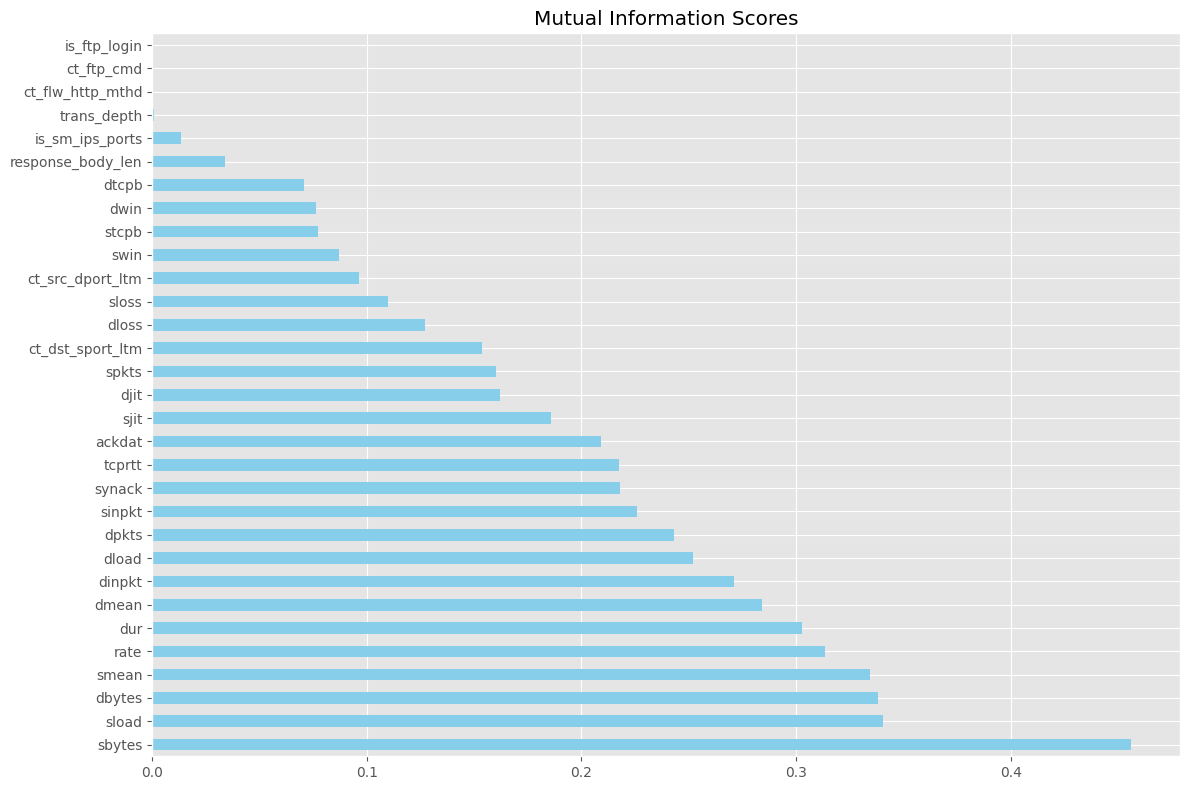

In [ ]:
# Data clean, pas de valeurs manquantes
# Replace '-' by 'None'
df['service'] = df['service'].astype(str).replace('-', 'None')
# Drop colonnes inutiles
df = df.drop(columns=['id','attack_cat'], errors='ignore')

# Mutual Information (optionnel)
# Sélectionner toutes les colonnes numériques sauf label
df_numeric_mi = df.select_dtypes(include=[np.number]).drop(columns=['label'], errors='ignore')
y_mi = df['label']
mi = mutual_info_classif(df_numeric_mi, y_mi, random_state=42)
mi_scores = pd.Series(mi, index=df_numeric_mi.columns).sort_values(ascending=False)
plt.figure(figsize=(12,8))
mi_scores.plot(kind='barh', color='skyblue')
plt.title('Mutual Information Scores')
plt.tight_layout()
plt.show()

In [ ]:
encoders = {}
for col in ['proto', 'service', 'state']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le  # Stockez l'encodeur dans le dictionnaire


X = df.drop(columns=['label'])
y = df['label']
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
tX, vX, tY, vY = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

def create_seq(X_df, y_ser, seq_len=10):
    buf = deque(maxlen=seq_len)
    Xs, ys = [], []
    for i in range(len(X_df)):
        buf.append(X_df.iloc[i].values)
        if len(buf)==seq_len:
            Xs.append(list(buf)); ys.append(y_ser.iloc[i])
    return np.array(Xs), np.array(ys)

seq_len = 10
X_train_seq, y_train_seq = create_seq(tX, tY, seq_len)
X_test_seq,  y_test_seq  = create_seq(vX, vY, seq_len)
print(f"Sequences shapes: train={X_train_seq.shape}, test={X_test_seq.shape}")

Sequences shapes: train=(180362, 10, 34), test=(77293, 10, 34)


In [ ]:
model = Sequential([
    LSTM(20, return_sequences=True, input_shape=(seq_len, X_train_seq.shape[2])),
    LSTM(20),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1, epochs=50, batch_size=2000,
    callbacks=[early_stop], verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5778 - loss: 0.6729 - val_accuracy: 0.6306 - val_loss: 0.6478
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6418 - loss: 0.6337 - val_accuracy: 0.6932 - val_loss: 0.5548
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7026 - loss: 0.5335 - val_accuracy: 0.7349 - val_loss: 0.4597
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7646 - loss: 0.4434 - val_accuracy: 0.8022 - val_loss: 0.4001
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8123 - loss: 0.3922 - val_accuracy: 0.8204 - val_loss: 0.3727
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8278 - loss: 0.3659 - val_accuracy: 0.8338 - val_loss: 0.3508
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8352 - loss: 0.3471 - val_accuracy: 0.8298 - val_loss: 0.3401
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8407 - loss: 0.3348 - val_accuracy: 0.8391 - v

2416/2416 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

      Normal       0.84      0.81      0.82     27893
      Attack       0.89      0.92      0.90     49400

    accuracy                           0.88     77293
   macro avg       0.87      0.86      0.86     77293
weighted avg       0.87      0.88      0.88     77293



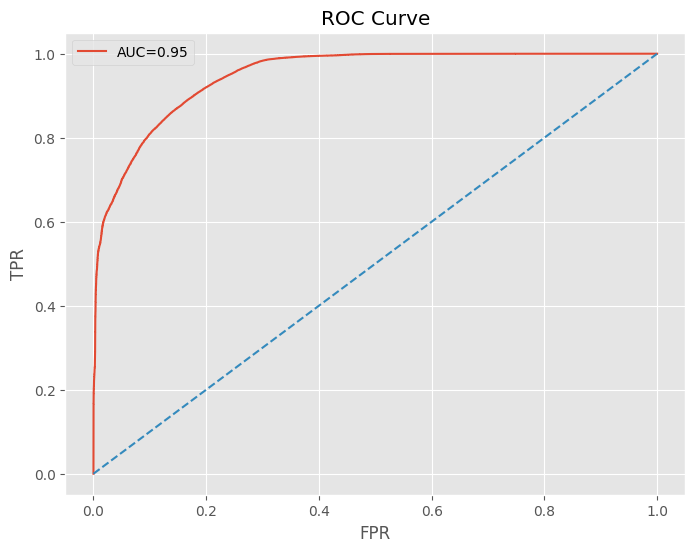

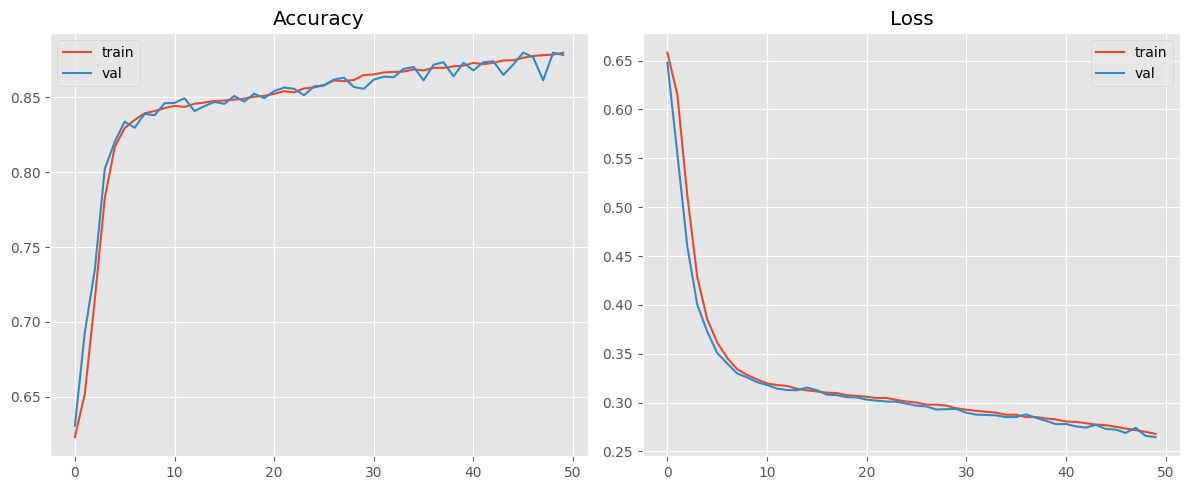

In [ ]:
# Rapport de classification
y_pred_prob = model.predict(X_test_seq).ravel()
y_pred = (y_pred_prob>0.5).astype(int)
print(classification_report(y_test_seq, y_pred, target_names=['Normal','Attack']))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_seq, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

# Training History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
import joblib
import torch
import json

# 1. Sauvegarde du modèle lstm_model
model.save_weights("lstm_model.weights.h5")  

# 2. Sauvegarde du scaler et de l’encodeur
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")  # 'le' est ton LabelEncoder utilisé sur 'proto', 'service', 'state'

# 3. Sauvegarde des noms de colonnes
feature_info = {
    "columns": list(X.columns),  # toutes les colonnes utilisées comme features
    "sequence_length": seq_len
}
with open("feature_info.json", "w") as f:
    json.dump(feature_info, f)

print("✅ Modèle, scaler, encodeur et infos de colonnes sauvegardés avec succès.")


✅ Modèle, scaler, encodeur et infos de colonnes sauvegardés avec succès.
